## Neural networks with time series data 

In [2]:
#Import necessary libraries

import pandas as pd
import numpy as np
from scipy import signal
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle as pkl
import itertools 
import glob
from sklearn import svm 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline 
# %matplotlib qt


In [10]:
# #Importing raw data files 

# #.csv path
# csvpath = "C:/Users/Wu Di/Documents/EEG-analysis/200108-Readings-csv/thinking-counting-switching.csv"

# #Read .csv files
# cols_to_use = list(range(4, 36))

# #Raw dataframes - each channel is a column
# raw_df = pd.read_csv(csvpath, header=None, usecols=cols_to_use)

# #Split into thinking and counting data frames
# think_index_list = []
# count_index_list = []

# for i in range(6):
#     if i%2==0:
#         think_index_list+=(list(range(1280*i,1280*(i+1))))
#     else:
#         count_index_list+=(list(range(1280*i,1280*(i+1))))


# # for i in range(len(all_bands_list)):
# #     df = all_bands_list[i].iloc[0:1280*6]
# df = raw_df.iloc[0:1280*6]
# df_list = np.vsplit(df,6)
# think_df = pd.DataFrame(np.vstack((df_list[0],df_list[2],df_list[4])))
# count_df = pd.DataFrame(np.vstack((df_list[1],df_list[3],df_list[5])))

# print(think_df.shape)
# print(count_df.shape)

# think_df.to_pickle("F:\EEG-data\\think-count\\raw/think.pkl")
# count_df.to_pickle("F:\EEG-data\\think-count\\raw/count.pkl")

(3840, 32)
(3840, 32)


In [6]:
# Import raw datasets, non-windowed 
think_df = pd.read_pickle("F:\EEG-data\\think-count\\raw/think.pkl")
count_df = pd.read_pickle("F:\EEG-data\\think-count\\raw/think.pkl")

print(think_df.shape)
print(count_df.shape)
print(think_df.iloc[0,0]) # Each element in dataframe is a single timestep
print(count_df.iloc[0,0])

(3840, 32)
(3840, 32)
26.553326000000002
26.553326000000002


In [3]:
tf.random.set_seed(10)

In [53]:
# Windowed dataset 

# history_size : size of past window of information
# target_size : how far in the future does the model need to learn to predict


# Testing on a single column 
testcol = think_df.iloc[:,0].values
# Normalize column 
testcol = keras.utils.normalize(testcol).flatten()

TRAIN_SPLIT = int(len(testcol)*0.8)
past_history = 12 #12 samples = 0.1s
future_target = 0 #predict voltage at the next timestep 


def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


X_train, y_train = univariate_data(testcol,0,TRAIN_SPLIT,past_history,future_target)
X_val, y_val = univariate_data(testcol,TRAIN_SPLIT,None,past_history,future_target)

<module 'matplotlib.pyplot' from 'C:\\Users\\Wu Di\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

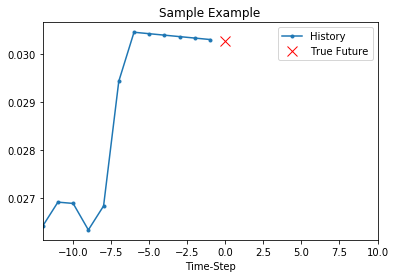

In [57]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

show_plot([X_train[10], y_train[10]], 0, 'Sample Example')


In [64]:
# tf.data to shuffle, batch, and cache the dataset 
BATCH_SIZE = 256
BUFFER_SIZE = 1000

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))#tensorflow TensorSliceDataset object
train_set = train_set.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() #tensorflow repeatDataset object

val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_set = val_set.batch(BATCH_SIZE).repeat()

In [67]:
simple_lstm_model = keras.models.Sequential([
    keras.layers.LSTM(8, input_shape=X_train.shape[-2:]),
    keras.layers.Dense(1) #predicting 1 value 
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

simple_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [81]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
history = simple_lstm_model.fit(train_set, epochs=EPOCHS,
                        steps_per_epoch=EVALUATION_INTERVAL, 
                        validation_data=val_set,validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 10/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0012 - val_loss: 0.00

In [113]:
forecast = np.zeros(len(y_val))
yvalues = np.zeros(len(y_val))

# for i, (x, y) in enumerate(val_set.take(len(y_val))):
#   forecast[i] = simple_lstm_model.predict(x)[0]
#   yvalues[i] = y[0].numpy()
    # print(x.shape)

# for x, y in val_set.take(10):
# #   plot = show_plot([x[0].numpy(), y[0].numpy(),
# #                     simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
# #   plot.show()
#     print(y[0].numpy())
               

In [104]:
keras.metrics.mean_absolute_error(yvalues,forecast).numpy()

0.0008644281172907315

In [7]:
# Testing on a single column 
testcol = think_df.iloc[:,0].values
# Normalize column 
testcol = keras.utils.normalize(testcol).flatten()

time = np.linspace(0,10,len(testcol))
split_time = int(len(testcol)*0.8)
time_train = time[:split_time]
x_train = testcol[:split_time]
time_valid = time[split_time:]
x_valid = testcol[split_time:]

window_size = 12
batch_size = 32
shuffle_buffer_size = 1000



def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset



In [154]:
tf.random.set_seed(10)
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
######### DNN Model ########
# DNN_model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
#     tf.keras.layers.Dense(10, activation="relu"), 
#     tf.keras.layers.Dense(1)
# ])
# DNN_model.compile(optimizer='adam', loss='mae')
# history = DNN_model.fit(dataset,epochs=10)

# DNN_model.compile(loss=tf.keras.losses.Huber(),
#               optimizer='adam',
#               metrics=["mae"])
# history = DNN_model.fit(dataset,epochs=10)

######### DNN Model1 ########

# dense2 = tf.keras.layers.Dense(10, activation="relu")
# DNN_model1 = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
#     dense2, 
#     tf.keras.layers.Dense(1)
# ])
# DNN_model1.compile(loss=tf.keras.losses.Huber(),
#               optimizer='adam',
#               metrics=["mae"])
# history = DNN_model1.fit(dataset,epochs=10)

######### DNN Model2 ########

lastDense = tf.keras.layers.Dense(1, activation="relu")
DNN_model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    lastDense
])
DNN_model2.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])
history = DNN_model2.fit(dataset,epochs=10)


###### LSTM Model ########
# LSTM_model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])

# LSTM_model.compile(optimizer='adam', loss='mae')
# history = LSTM_model.fit(dataset,epochs=10)

# LSTM_model.compile(loss=tf.keras.losses.Huber(),
#               optimizer='adam',
#               metrics=["mae"])
# history = LSTM_model.fit(dataset,epochs=10)


###### Simple RNN model ######
# RNN_model = tf.keras.models.Sequential([
#   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#   tf.keras.layers.SimpleRNN(40, return_sequences=True),
#   tf.keras.layers.SimpleRNN(40),
#   tf.keras.layers.Dense(1),
#   # tf.keras.layers.Lambda(lambda x: x * 100.0)
# ])

# RNN_model.compile(loss=tf.keras.losses.Huber(),
#               optimizer='adam',
#               metrics=["mae"])
# history = RNN_model.fit(dataset,epochs=10)

####### Conv1D + LSTM ########
# conv_LSTM_model = tf.keras.models.Sequential([
#     tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                       input_shape=[None]),
#   tf.keras.layers.Conv1D(filters=32, kernel_size=5,
#                       strides=1, padding="causal",
#                       activation="relu",
#                       input_shape=[None,1]),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#   tf.keras.layers.Dense(1),
#   tf.keras.layers.Lambda(lambda x: x * 200)
# ])

# conv_LSTM_model.compile(loss=tf.keras.losses.Huber(),
#               optimizer='adam',
#               metrics=["mae"])
# history = conv_LSTM_model.fit(dataset,epochs=10)

Epoch 1/10
96/96 [==============================] - 1s 7ms/step - loss: 5.5827e-05 - mae: 0.0058
Epoch 2/10
96/96 [==============================] - 1s 7ms/step - loss: 4.8825e-05 - mae: 0.0049
Epoch 3/10
96/96 [==============================] - 1s 5ms/step - loss: 4.8243e-05 - mae: 0.0047
Epoch 4/10
96/96 [==============================] - 1s 7ms/step - loss: 4.8039e-05 - mae: 0.0047
Epoch 5/10
96/96 [==============================] - 1s 7ms/step - loss: 4.7929e-05 - mae: 0.0047
Epoch 6/10
96/96 [==============================] - 1s 8ms/step - loss: 4.7697e-05 - mae: 0.0046
Epoch 7/10
96/96 [==============================] - 1s 8ms/step - loss: 4.7566e-05 - mae: 0.0045
Epoch 8/10
96/96 [==============================] - 1s 7ms/step - loss: 4.7506e-05 - mae: 0.0045
Epoch 9/10
96/96 [==============================] - 0s 5ms/step - loss: 4.7530e-05 - mae: 0.0046
Epoch 10/10
96/96 [==============================] - 1s 6ms/step - loss: 4.7417e-05 - mae: 0.0045


In [144]:
# forecast = np.zeros(len(testcol))
# forecast = []
# for i,time in enumerate(range(len(testcol) - window_size)):
#   forecast.append(RNN_model.predict(testcol[time:time + window_size][np.newaxis]))



In [155]:
forecast = np.zeros(len(testcol)-window_size)
for i,time in enumerate(range(len(testcol) - window_size)):
  forecast[i]=(DNN_model2.predict(testcol[time:time + window_size][np.newaxis]))



In [152]:
print(len(forecast))
# results = np.array(forecast[split_time-window_size:])[:, 0, 0]
results = forecast[split_time-window_size:]
print(results.shape)
print(x_valid.shape)

3828
(768,)
(768,)


In [141]:
x_valid.shape
results = results.flatten()
results.shape

(768,)

In [156]:
##LSTM Model, 0.0035024881
# LSTM_mae = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# print(LSTM_mae)

##DNN Model, 0.0016933586
# DNN_mae = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# print(DNN_mae)

##RNN Model, 0.012511288
# RNN_mae = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# print(RNN_mae)

#with lambda layer = 0.018520547

##Conv_lstm Model, no lambda layer, 0.004550955
# conv_LSTM_mae = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# print(conv_LSTM_mae)

##Conv_lstm Model, with lambda layer, 
# conv_LSTM_mae1 = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# print(conv_LSTM_mae1)


##DNN get weights 0.0014220929
# DNN1_mae = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
DNN2_mae = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()


print(DNN1_mae)
print(DNN2_mae)


0.002966318911459096
0.002966318911459096


In [117]:
forecast = np.array(forecast)

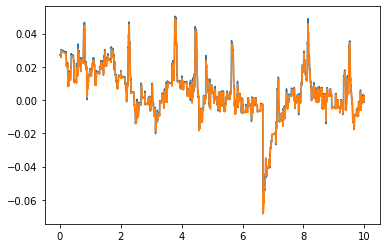

In [118]:
time = np.linspace(0,10,len(testcol))
plt.plot(time,testcol)
# plt.plot(time_valid,forecast)
plt.plot(time[len(testcol)-len(forecast):],forecast[:,0,0])


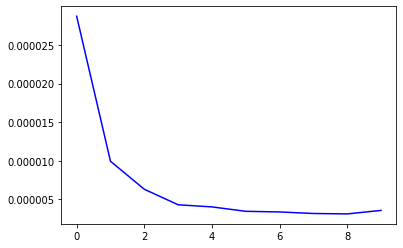

In [119]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

In [125]:
DNN_model1.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 10)                130       
_________________________________________________________________
dense_29 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 11        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


In [158]:
weights = lastDense.get_weights()
weights

[array([[ 0.15423389],
        [-0.49636358],
        [ 0.62095976],
        [ 0.5569767 ],
        [ 0.42562002],
        [ 0.0293335 ],
        [ 0.03387152],
        [ 0.31214735],
        [ 0.62615544],
        [-0.3266601 ]], dtype=float32), array([-0.00978807], dtype=float32)]